In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


c:\Users\kaushal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\kaushal\AppData\Local\Programs\Python\Python310\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\kaushal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

# Set the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Set the path to your dataset
dataset_dir = ""

# Set the input size for resizing the images
input_size = (128,128)

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])


In [4]:
# Load the training dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the test dataset
test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Load the pre-trained GoogLeNet model
model = googlenet(pretrained=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\kaushal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaushal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_accuracy = train_correct / len(train_dataset)
    train_loss /= len(train_loader)

    # Evaluation on the test set
    model.eval()
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / len(test_dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f}")


Epoch [1/20] Train Loss: 0.6786 Train Accuracy: 0.7524 Test Accuracy: 0.9089
Epoch [2/20] Train Loss: 0.2249 Train Accuracy: 0.9274 Test Accuracy: 0.9567
Epoch [3/20] Train Loss: 0.1475 Train Accuracy: 0.9504 Test Accuracy: 0.9511
Epoch [4/20] Train Loss: 0.1145 Train Accuracy: 0.9609 Test Accuracy: 0.7351
Epoch [5/20] Train Loss: 0.0915 Train Accuracy: 0.9741 Test Accuracy: 0.9570
Epoch [6/20] Train Loss: 0.1211 Train Accuracy: 0.9603 Test Accuracy: 0.9441
Epoch [7/20] Train Loss: 0.1034 Train Accuracy: 0.9678 Test Accuracy: 0.9340
Epoch [8/20] Train Loss: 0.0919 Train Accuracy: 0.9750 Test Accuracy: 0.7484
Epoch [9/20] Train Loss: 0.0861 Train Accuracy: 0.9852 Test Accuracy: 0.9655
Epoch [10/20] Train Loss: 0.0521 Train Accuracy: 0.9859 Test Accuracy: 0.9518
Epoch [11/20] Train Loss: 0.0845 Train Accuracy: 0.9770 Test Accuracy: 0.9418
Epoch [12/20] Train Loss: 0.0382 Train Accuracy: 0.9882 Test Accuracy: 0.9685
Epoch [13/20] Train Loss: 0.0231 Train Accuracy: 0.9934 Test Accuracy: 0.

In [7]:
# Uncomment below lines to save model
# # Path for the saved model
path = './models2/gnet.pt'
# Comment out below line if you have already saved model and just want to retrieve it (not saving)
torch.save(model.state_dict(), path)

In [8]:
# Calculate the final accuracy on the entire test dataset
model.load_state_dict(torch.load(path))
model.eval()
test_correct = 0

preds_tensor = torch.Tensor()
labels_tensor = torch.Tensor()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds_tensor = torch.cat((preds_tensor, predicted))
        labels_tensor = torch.cat((labels_tensor, labels))
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = test_correct / len(test_dataset)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


Final Test Accuracy: 0.9770


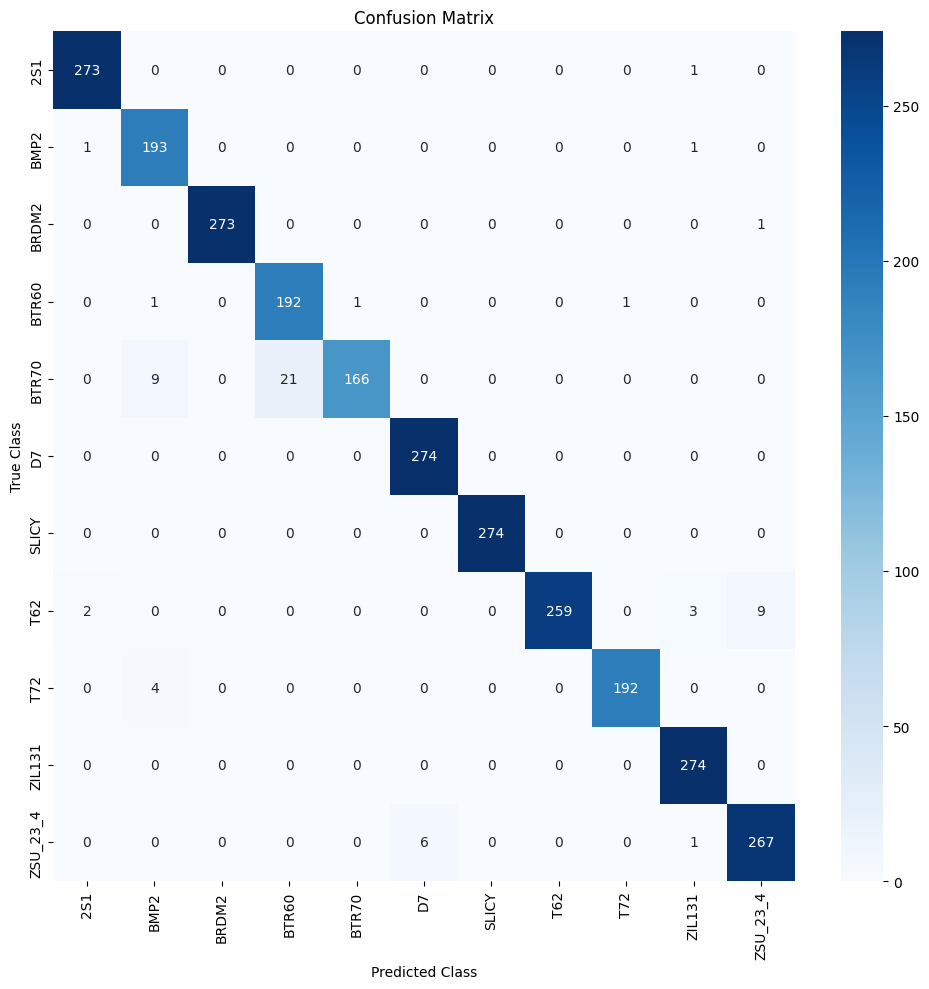

In [9]:
preds = preds_tensor.numpy()
actual = labels_tensor.numpy()

# Define the mapping dictionary
class_mapping = {
    0: '2S1',
    1: 'BMP2',
    2: 'BRDM2',
    3: 'BTR60',
    4: 'BTR70',
    5: 'D7',
    6: 'SLICY',
    7: 'T62',
    8: 'T72',
    9: 'ZIL131',
    10: 'ZSU_23_4'
}

y_preds = np.array([class_mapping[value] for value in preds])
y_true = np.array([class_mapping[value] for value in actual])

class_labels = ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70',
                'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_preds, labels=class_labels)

# Set figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Configure figure properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()

# Show the figure
plt.show()


In [10]:
class_wise_accuracies = np.diag(cm) / cm.sum(axis=1)

# Display the class-wise accuracies
for i, accuracy in enumerate(class_wise_accuracies):
    label = class_labels[i]
    print(f'Accuracy of class {label}: {accuracy:.2%}')


Accuracy of class 2S1: 99.64%
Accuracy of class BMP2: 98.97%
Accuracy of class BRDM2: 99.64%
Accuracy of class BTR60: 98.46%
Accuracy of class BTR70: 84.69%
Accuracy of class D7: 100.00%
Accuracy of class SLICY: 100.00%
Accuracy of class T62: 94.87%
Accuracy of class T72: 97.96%
Accuracy of class ZIL131: 100.00%
Accuracy of class ZSU_23_4: 97.45%


In [12]:
# Histograms
train_labels = train_dataset.targets
test_labels = test_dataset.targets

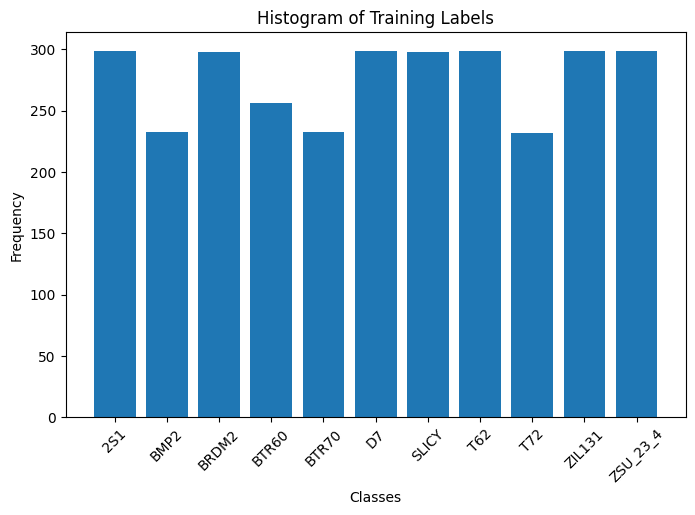

In [14]:
# Histogram of training labels
class_names = train_dataset.classes
plt.figure(figsize=(8, 5))
plt.hist(train_labels, bins=np.arange(num_classes + 1) - 0.5, rwidth=0.8, align='mid')
plt.xticks(np.arange(num_classes), class_names, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Training Labels')
plt.show()


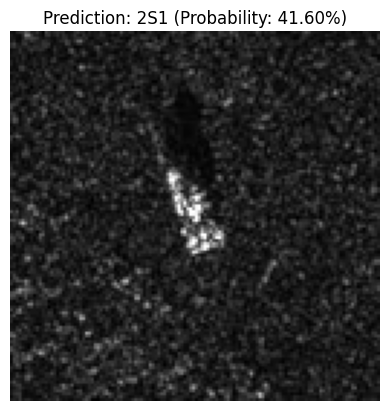

2S1: 41.60%
BMP2: 22.20%
BRDM2: 0.12%
BTR60: 20.55%
BTR70: 0.06%
D7: 4.41%
SLICY: 0.05%
T62: 1.63%
T72: 7.68%
ZIL131: 0.33%
ZSU_23_4: 1.37%


In [26]:
import numpy as np
from PIL import Image


# Prediction on a single image
def predict_single_image(image, model, device, transform, class_names):
    model.eval()

    if isinstance(image, str):  # If image is a file path, load it using PIL
        image = Image.open(image)

    # If the image has only one channel, convert it to RGB
    if image.mode == 'L':
        image = image.convert('RGB')

    # Resize the image to the desired input size
    image = image.resize((128, 128))

    # Convert the image to a NumPy array and normalize the values
    image = np.array(image, dtype=np.float32) / 255.0

    # Convert the NumPy array to a PyTorch tensor
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)
        probability = torch.softmax(output, dim=1)[0] * 100

    class_name = class_names[predicted_class.item()]
    probability_percent = probability[predicted_class.item()].item()

    # Get probabilities for all classes
    all_probabilities = probability.cpu().numpy()

    # Create a dictionary to store class probabilities
    class_probabilities = {class_names[i]: prob.item() for i, prob in enumerate(all_probabilities)}

    plt.imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))
    plt.title(f"Prediction: {class_name} (Probability: {probability_percent:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_probabilities

# Get prediction for a user-input image
user_input_image = "test/2S1/HB14932.jpeg"  # Replace with the actual file name of the image
class_probabilities = predict_single_image(user_input_image, model, device, transform, class_names)

# Print probabilities of all classes
for class_name, probability in class_probabilities.items():
    print(f"{class_name}: {probability:.2f}%")
